In [1]:
import pandas as pd
from keras.optimizers import Adam

from processors import QueProc, StuProc, ProProc
from generator import BatchGenerator
from models import DistanceModel as Mothership
from evaluation import permutation_importance, plot_fi

Using TensorFlow backend.
D:\Apps\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
%load_ext line_profiler

In [3]:
data_path, dump_path, split_date = '../../data/', 'dump/', '2018-09-01'

In [4]:
train, test = dict(), dict()

In [5]:
print('Raw data shapes:')
for var, file_name in [('que', 'questions.csv'), ('ans', 'answers.csv'),
                       ('pro', 'professionals.csv'), ('stu', 'students.csv')]:
    df = pd.read_csv(data_path + file_name)

    date_col = [col for col in df.columns if 'date' in col][0]
    df[date_col] = pd.to_datetime(df[date_col])

    train[var] = df[df[date_col] < split_date]
    test[var] = df

    print(var, train[var].shape, test[var].shape)

tags = pd.read_csv(data_path + 'tags.csv')
tag_que = pd.read_csv(data_path + 'tag_questions.csv') \
    .merge(tags, left_on='tag_questions_tag_id', right_on='tags_tag_id')
tag_pro = pd.read_csv(data_path + 'tag_users.csv') \
    .merge(tags, left_on='tag_users_tag_id', right_on='tags_tag_id')
print('tag_que', tag_que.shape)
print('tag_pro', tag_pro.shape)

Raw data shapes:
que (22726, 5) (23931, 5)
ans (45838, 5) (51123, 5)
pro (22658, 5) (28152, 5)
stu (29631, 3) (30971, 3)
tag_que (76553, 4)
tag_pro (136663, 4)


## LDA

In [16]:
import doc2vec
import importlib

In [33]:
importlib.reload(doc2vec)

<module 'doc2vec' from 'C:\\Users\\dell\\Notebooks\\cv\\proj\\doc2vec.py'>

In [34]:
doc2vec.pipeline(train['que'], train['ans'], train['pro'], tag_que, 10, dump_path)

---

In [6]:
mode, data, oblige_fit, nonneg_pairs = 'Train', train, True, []

In [7]:
# mappings from professional's id to his registration date. Used in batch generator
pro_dates = {row['professionals_id']: row['professionals_date_joined'] for i, row in data['pro'].iterrows()}

# construct dataframe used to extract positive pairs
df = data['que'].merge(data['ans'], left_on='questions_id', right_on='answers_question_id') \
    .merge(data['pro'], left_on='answers_author_id', right_on='professionals_id') \
    .merge(data['stu'], left_on='questions_author_id', right_on='students_id')
if mode == 'Test':
    df = df.loc[df['answers_date_added'] >= split_date]
# else:
#     df = df.loc[df['answers_date_added'] >= '2016-01-01'] # experiment
df = df[['questions_id', 'students_id', 'professionals_id', 'answers_date_added']]

# extract positive pairs, non-negative pairs are all known positive pairs to the moment
pos_pairs = list(df.itertuples(index=False, name=None))
nonneg_pairs += pos_pairs
print(f'Positive pairs number: {len(pos_pairs)}, negative: {len(nonneg_pairs)}')

Positive pairs number: 44474, negative: 44474


In [8]:
que_proc = QueProc(oblige_fit, dump_path)
que_data = que_proc.transform(data['que'], tag_que)
print('Questions: ', que_data.shape)

stu_proc = StuProc(oblige_fit, dump_path)
stu_data = stu_proc.transform(data['stu'], data['que'], data['ans'])
print('Students: ', stu_data.shape)

pro_proc = ProProc(oblige_fit, dump_path)
pro_data = pro_proc.transform(data['pro'], data['que'], data['ans'], tag_pro)
print('Professionals: ', pro_data.shape)

D:\Apps\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Apps\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Apps\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Apps\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

D:\Apps\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Apps\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Apps\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Apps\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

FileNotFoundError: [Errno 2] No such file or directory: 'dump/questions.d2v'

In [9]:
import generator

In [10]:
import importlib

In [11]:
importlib.reload(generator)

<module 'generator' from 'C:\\Users\\nikitosoleil\\DataRoot\\cv\\cv\\proj\\generator.py'>

In [19]:
bg = generator.BatchGenerator(que_data, stu_data, pro_data, 64, pos_pairs, nonneg_pairs,
                            que_proc.pp['questions_date_added_time'], pro_dates)

In [14]:
%lprun -f bg._BatchGenerator__convert bg.__getitem__(0)

In [15]:
%lprun -f bg.__getitem__ bg.__getitem__(0)

In [20]:
%%timeit 
bg[0]

7.14 ms ± 595 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
(x_pro, x_que), y = bg[0]

In [22]:
x_pro.shape, x_que.shape, y.shape

((128, 18), (128, 25), (128, 1))

In [23]:
model = Mothership(que_dim=len(que_data.columns) - 2 + len(stu_data.columns) - 2,
                               que_input_embs=[102, 42], que_output_embs=[2, 2],
                               pro_dim=len(pro_data.columns) - 2,
                               pro_input_embs=[102, 102, 42], pro_output_embs=[2, 2, 2], inter_dim=10)

In [24]:
model.compile(Adam(lr=0.005), loss='binary_crossentropy', metrics=['accuracy'])
model.fit_generator(bg, epochs=10, verbose=2)

Epoch 1/10
 - 9s - loss: 0.6105 - acc: 0.6852
Epoch 2/10
 - 7s - loss: 0.5498 - acc: 0.7238
Epoch 3/10
 - 8s - loss: 0.5443 - acc: 0.7285
Epoch 4/10
 - 8s - loss: 0.5398 - acc: 0.7307
Epoch 5/10
 - 7s - loss: 0.5375 - acc: 0.7328
Epoch 6/10
 - 7s - loss: 0.5344 - acc: 0.7367
Epoch 7/10
 - 7s - loss: 0.5305 - acc: 0.7399
Epoch 8/10
 - 7s - loss: 0.5294 - acc: 0.7393
Epoch 9/10
 - 7s - loss: 0.5278 - acc: 0.7409
Epoch 10/10
 - 7s - loss: 0.5266 - acc: 0.7421


In [25]:
bg = BatchGenerator(que_data, stu_data, pro_data, 1024, pos_pairs, nonneg_pairs,
                            que_proc.pp['questions_date_added_time'], pro_dates)

In [26]:
fn = {"que": list(stu_data.columns[2:]) + list(que_data.columns[2:]),  # + ['que_current_time'],
              "pro": list(pro_data.columns[2:]),  # + ['pro_current_time'],
              'text': [f'que_tag_emb_{i}' for i in range(10)] +
                      [f'pro_tag_emb_{i}' for i in range(10)] + [f'pro_ind_emb_{i}' for i in range(10)]}

In [27]:
fi = permutation_importance(model, bg[0][0][0], bg[0][0][1], bg[0][1], fn, n_trials=3)

2048/2048 [==============================] - ETA:  - ETA:  - 0s 94us/step


Feature importance: 100%|██████████████████████████████████████████████████████████████| 43/43 [00:22<00:00,  2.13it/s]


In [30]:
from matplotlib import pyplot as plt
from jupyterthemes import jtplot

jtplot.style('gruvboxd')

In [51]:
def plot_fi(fi, title='Feature importances via shuffle', xlabel='Change in loss after shuffling feature\'s values'):
    """
    Nicely plot Pandas DataFrame with feature importance
    """
    def get_color(feature: str):
        if feature.startswith('que'):
            if '_emb_' in feature:
                return 'slateblue'
            else:
                return 'mediumpurple'
        elif feature.startswith('pro'):
            if '_emb_' in feature:
                return 'sienna'
            else:
                return 'peru'
        else:
            return 'teal'

    fi['color'] = fi.index.map(get_color)
    fig, ax = plt.subplots(figsize=(8, 20))
    plt.barh(fi.index, fi.importance, color=fi.color)
    plt.title(title)
    plt.xlabel(xlabel)
    ax.yaxis.tick_right()
    plt.show()

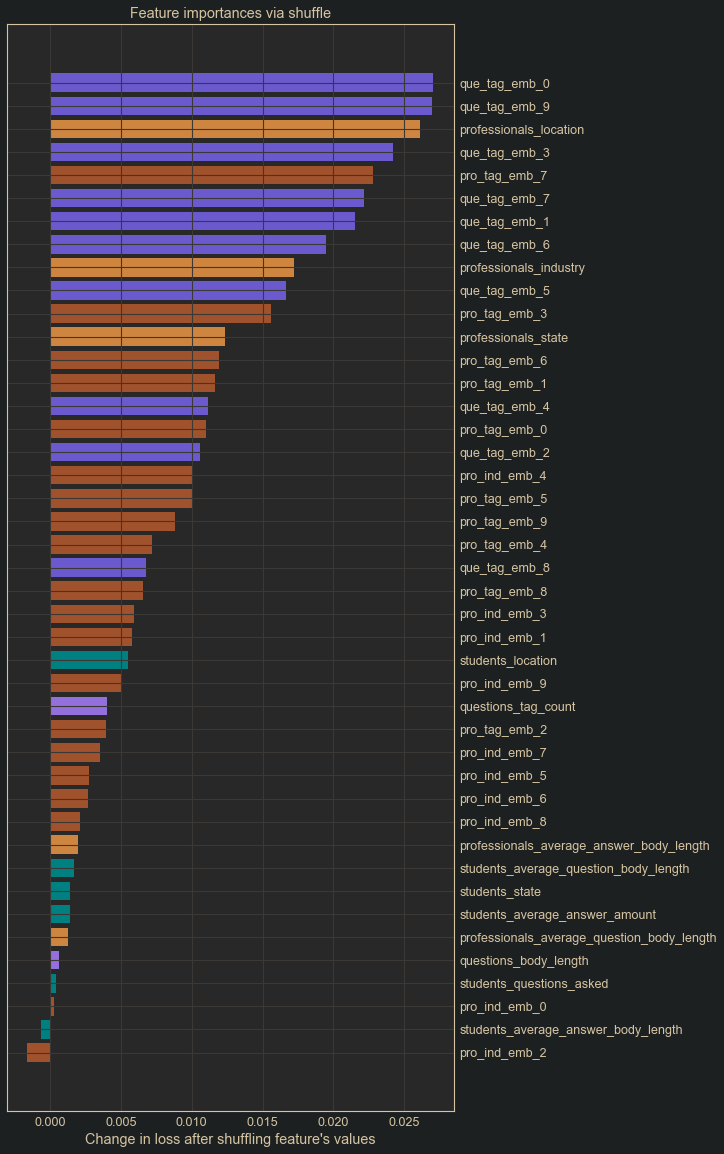

In [52]:
plot_fi(fi)

In [34]:
(x_que, x_pro), y = bg[0]

In [35]:
model.evaluate([x_que, x_pro], y)

128/128 [==============================] - ETA:  - 1s 7ms/step


[0.506597638130188, 0.71875]

In [36]:
model.predict([x_que, x_pro])

array([[0.7055055 ],
       [0.5064023 ],
       [0.6624529 ],
       [0.84877807],
       [0.8438728 ],
       [0.849266  ],
       [0.49013442],
       [0.24255759],
       [0.7481267 ],
       [0.6762347 ],
       [0.8412254 ],
       [0.4565693 ],
       [0.80040264],
       [0.7454783 ],
       [0.71673393],
       [0.83821315],
       [0.44110608],
       [0.65732443],
       [0.91251606],
       [0.71041435],
       [0.76030177],
       [0.51636755],
       [0.70084983],
       [0.8364926 ],
       [0.57808626],
       [0.6049208 ],
       [0.7906761 ],
       [0.38490355],
       [0.43028942],
       [0.492154  ],
       [0.7513127 ],
       [0.7695412 ],
       [0.8469523 ],
       [0.6700782 ],
       [0.48239726],
       [0.76612544],
       [0.5901962 ],
       [0.5757282 ],
       [0.16469707],
       [0.8392781 ],
       [0.3657336 ],
       [0.6997059 ],
       [0.6986404 ],
       [0.36715814],
       [0.26786062],
       [0.7630719 ],
       [0.8875063 ],
       [0.882

In [37]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None,)              0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None,)              0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_13 

In [24]:
model.get_layer('dense_3').get_weights()

[array([[ 1.4143994e-04, -1.3392113e-04, -5.6161231e-04,  2.1745509e-04,
         -1.4326230e-04, -8.9885296e-05,  3.2230248e-04, -3.3190950e-05,
          1.4186190e-03, -1.2606838e-03],
        [ 3.2545204e-04, -5.2264746e-04, -2.7708989e-04,  3.9670884e-04,
         -2.9978468e-04, -1.9088780e-05,  7.6369336e-04, -8.0372905e-05,
          5.2403135e-04, -4.5995764e-04],
        [-5.3416920e-04,  4.6521777e-04,  3.5782135e-04, -8.9504063e-04,
          4.3566985e-04,  4.1023904e-05, -1.2533442e-03,  1.4640916e-04,
         -8.0962956e-04,  8.6132769e-04],
        [ 2.6368264e-03, -8.1224594e-04, -1.4238412e-03,  1.2487689e-03,
         -1.4999670e-03, -1.6713682e-04,  3.7049288e-03, -6.9209398e-04,
          1.4529637e-03, -4.7662137e-03],
        [ 2.2997775e-03, -2.5678200e-03, -2.3778972e-04,  1.6174705e-03,
         -9.3669404e-04, -1.6419201e-04,  3.5139660e-03, -4.1729779e-04,
          1.3356778e-03, -2.5706592e-03],
        [-6.7985826e-04,  1.4926733e-03,  7.7403430e-04, -1.

# Check embeddings

In [119]:
from gensim.models.doc2vec import Doc2Vec
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [122]:
d2v = Doc2Vec.load('dump/tags.d2v')

In [123]:
proj = TSNE(n_components = 2, verbose = 1).fit_transform(d2v.docvecs.vectors_docs)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5604 samples in 0.004s...
[t-SNE] Computed neighbors for 5604 samples in 0.817s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5604
[t-SNE] Computed conditional probabilities for sample 2000 / 5604
[t-SNE] Computed conditional probabilities for sample 3000 / 5604
[t-SNE] Computed conditional probabilities for sample 4000 / 5604
[t-SNE] Computed conditional probabilities for sample 5000 / 5604
[t-SNE] Computed conditional probabilities for sample 5604 / 5604
[t-SNE] Mean sigma: 0.529536
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.478920
[t-SNE] KL divergence after 1000 iterations: 1.727014


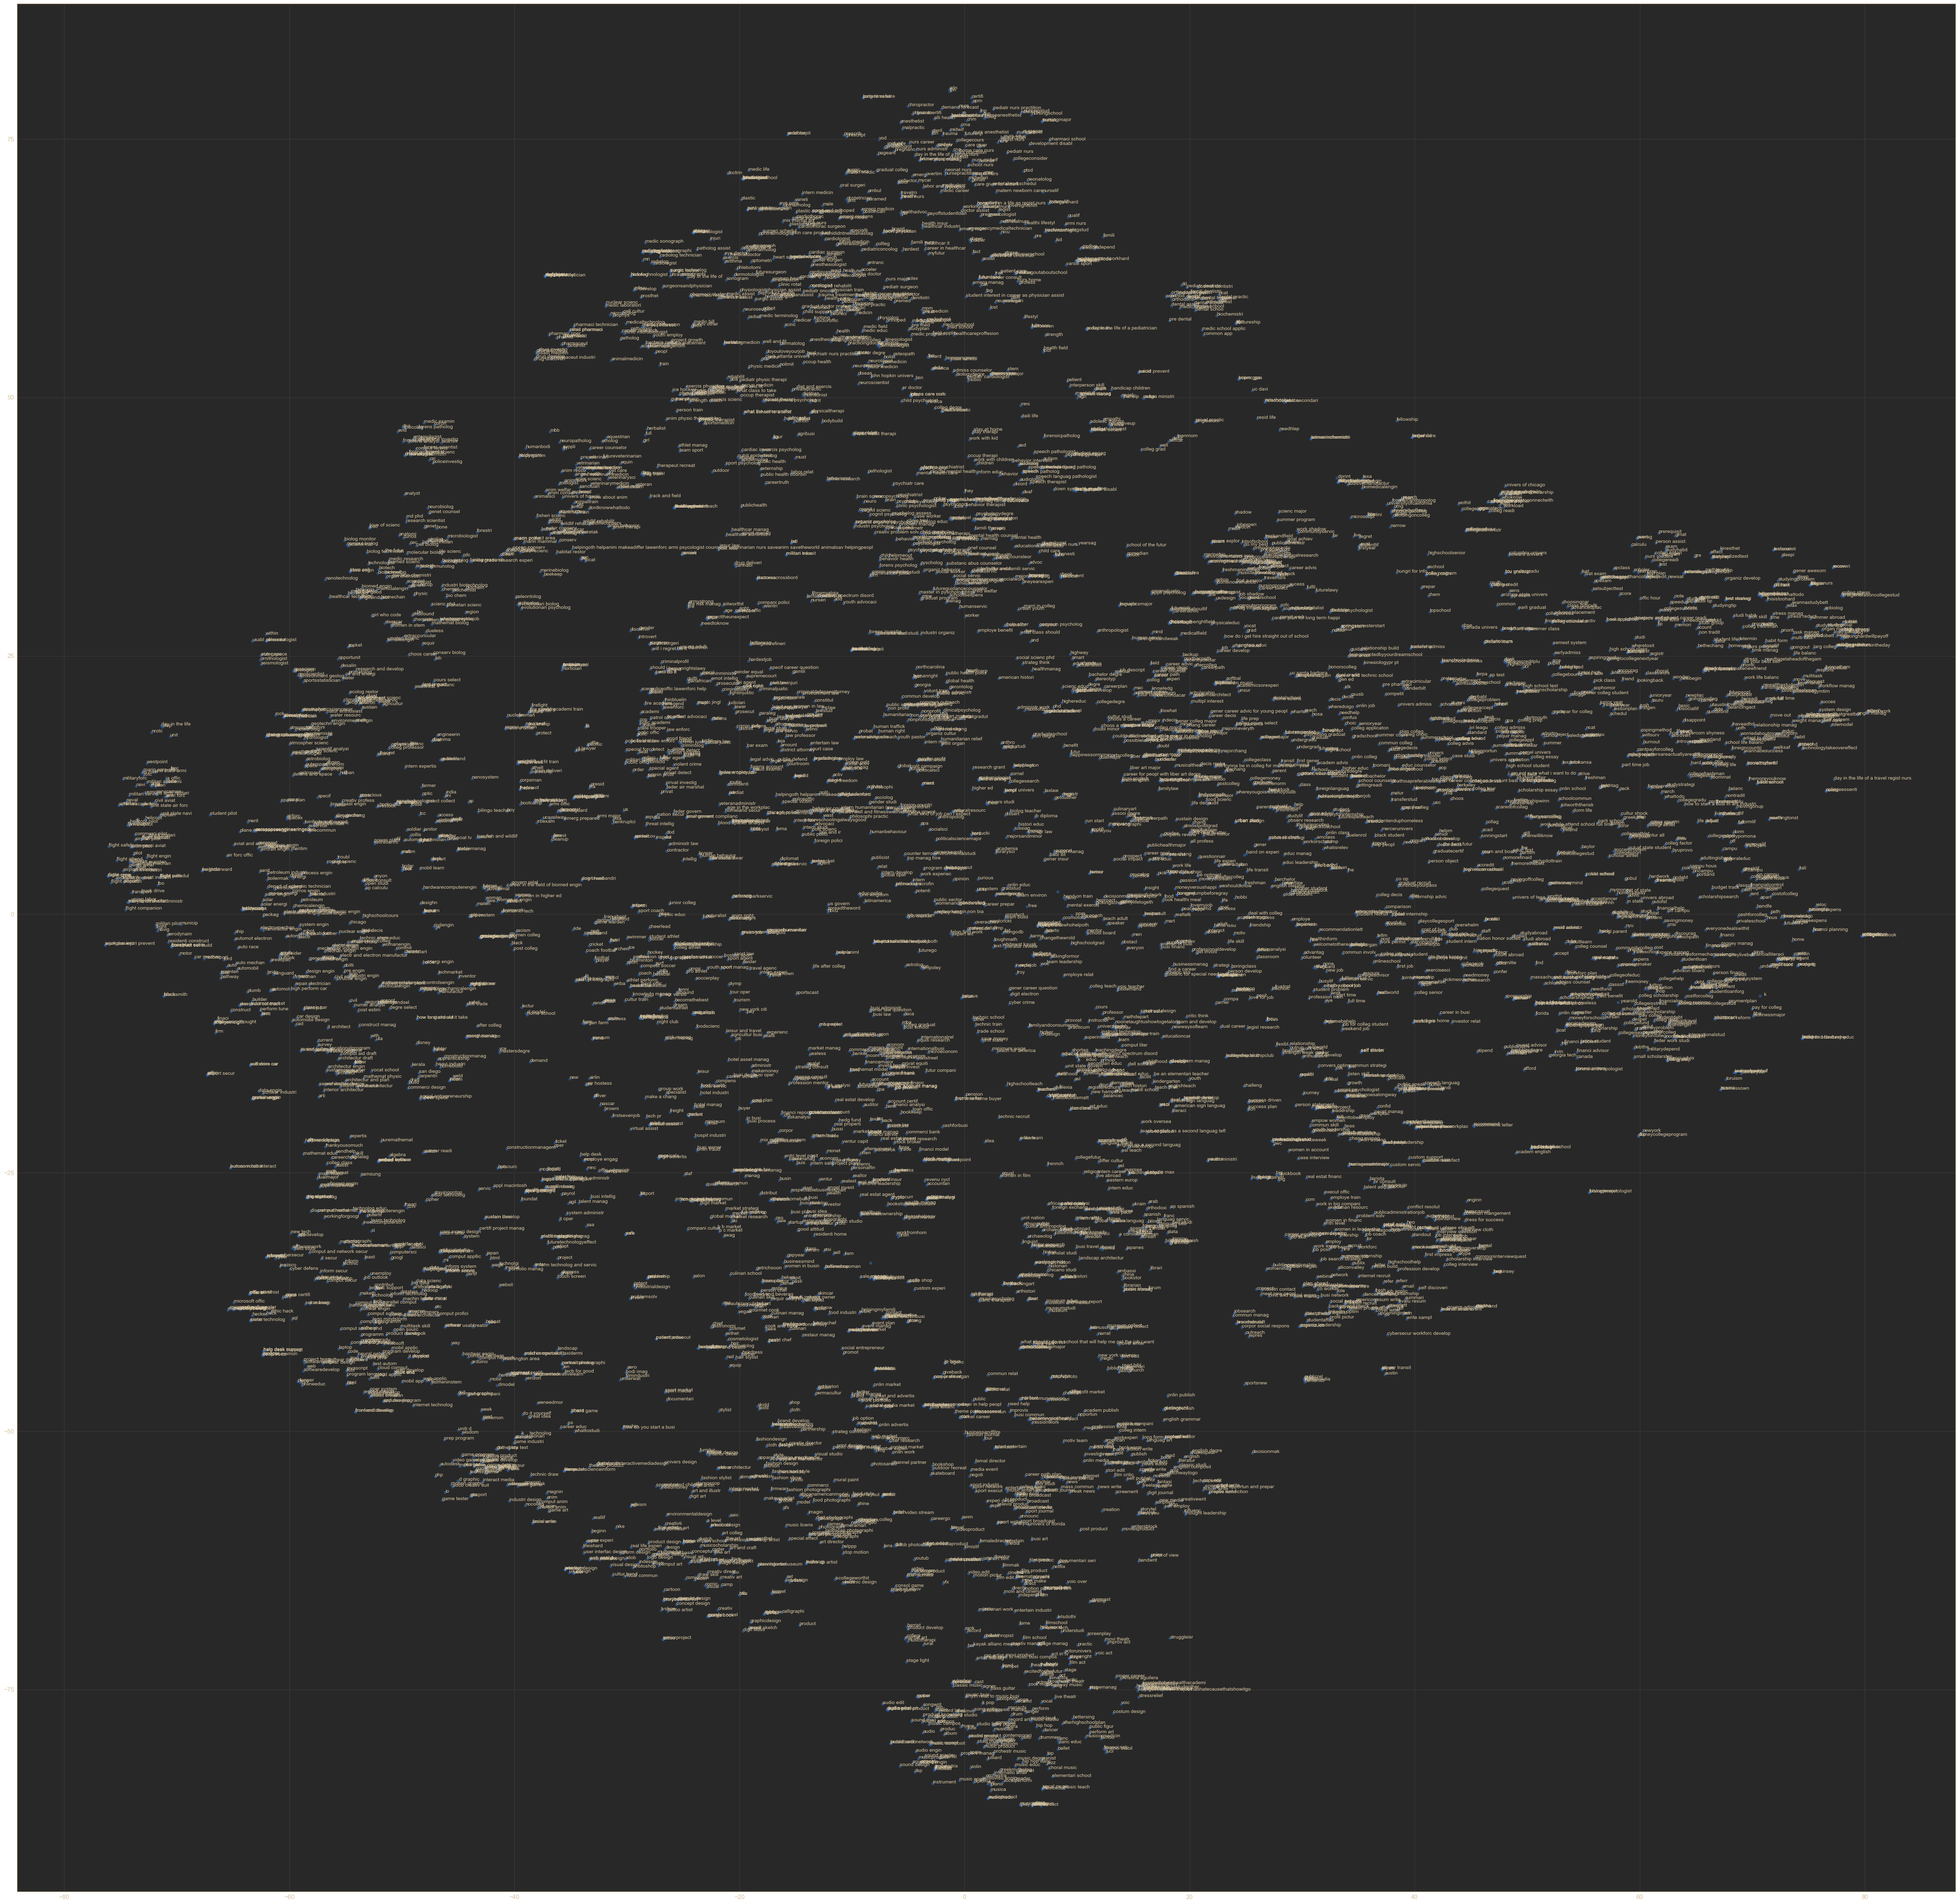

In [126]:
fig, ax = plt.subplots(figsize = (70, 70))

plt.scatter(proj[:, 0], proj[:, 1], alpha = 0.5)

for i, name in (enumerate(d2v.docvecs.index2entity)):
    ax.annotate(name, (proj[i, 0], proj[i, 1]))

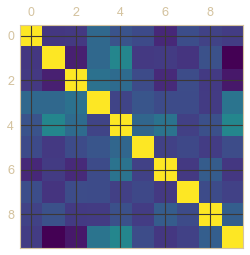

In [125]:
plt.matshow(pd.DataFrame(d2v.docvecs.vectors_docs).corr())